In [1]:
##MULTI_STOCK DATA + FEATURE ENGINEERING

!pip install yfinance --quiet
import yfinance as yf
import pandas as pd
import numpy as np

#Define tickers and download historical OHLCV data
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
data = yf.download(tickers, start= '2018-01-01', end = '2023-01-01', group_by='ticker', auto_adjust=True)

##Create a dictionary to hold individual stock Dataframes
stock_data = {}
for ticker in tickers:
  df= data[ticker].copy()
  df.dropna(inplace=True)
  df['Ticker'] = ticker
  stock_data[ticker] = df

[*********************100%***********************]  5 of 5 completed


In [2]:
df

Price,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,65283000,TSLA
2018-01-03,21.400000,21.683332,21.036667,21.150000,67822500,TSLA
2018-01-04,20.858000,21.236668,20.378668,20.974667,149194500,TSLA
2018-01-05,21.108000,21.149332,20.799999,21.105333,68868000,TSLA
2018-01-08,21.066668,22.468000,21.033333,22.427334,147891000,TSLA
...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,166989700,TSLA
2022-12-27,117.500000,119.669998,108.760002,109.099998,208643400,TSLA
2022-12-28,110.349998,116.269997,108.239998,112.709999,221070500,TSLA


In [3]:
# ✅ Define a function to compute features per stock
def compute_features(df):
    df = df.copy()

    # 1-day and 5-day returns
    df['Return_1d'] = df['Close'].pct_change()
    df['Return_5d'] = df['Close'].pct_change(5)

    # 5-day and 20-day simple moving averages
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # 14-day Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(14).mean()
    avg_loss = pd.Series(loss).rolling(14).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # 5-day rolling volatility (standard deviation of daily returns)
    df['Volatility_5d'] = df['Return_1d'].rolling(window=5).std()

    # Price imbalance (SMA ratio)
    df['SMA_Ratio'] = df['SMA_5'] / (df['SMA_20'] + 1e-10)

    return df


In [4]:
# ✅ Apply feature engineering to all tickers
for ticker in tickers:
    stock_data[ticker] = compute_features(stock_data[ticker])

stock_data

{'AAPL': Price             Open        High         Low       Close     Volume Ticker  \
 Date                                                                           
 2018-01-02   39.933975   40.436201   39.722757   40.426811  102223600   AAPL   
 2018-01-03   40.490183   40.964248   40.356415   40.419777  118071600   AAPL   
 2018-01-04   40.492536   40.710794   40.384583   40.607533   89738400   AAPL   
 2018-01-05   40.703743   41.156683   40.612216   41.069851   94640000   AAPL   
 2018-01-08   40.917320   41.213022   40.818749   40.917320   82271200   AAPL   
 ...                ...         ...         ...         ...        ...    ...   
 2022-12-23  129.245801  130.726619  127.982170  130.173782   63814900   AAPL   
 2022-12-27  129.699945  129.729560  127.073957  128.367203   69007800   AAPL   
 2022-12-28  128.011792  129.354401  124.260391  124.428215   85438400   AAPL   
 2022-12-29  126.353282  128.811438  126.096612  127.952568   75703700   AAPL   
 2022-12-30  126.767

##CODE LABELING AND COMBINING ALL THE STOCKS

In [5]:
data_all = []

for ticker in tickers:
    df = stock_data[ticker].copy()

    df['1d_return'] = df['Close'].pct_change()
    df['5d_return'] = df['Close'].pct_change(5)
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['Volatility_5d'] = df['Close'].rolling(window=5).std()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # Label
    df['Future_5d_Return'] = df['Close'].shift(-5) / df['Close'] - 1
    df['Label'] = (df['Future_5d_Return'] > 0).astype(int)

    df['Ticker'] = ticker
    data_all.append(df)

# Concatenate all tickers
data_all = pd.concat(data_all)

# Now drop rows with any NaNs
data_all.dropna(inplace=True)

In [6]:
len(data_all)

6175

In [7]:
#Minor fixes:
data_all = data_all.reset_index()  # 'Date' becomes a column again
data_all = data_all.set_index(['Date', 'Ticker'])  # set multi-index

In [8]:
print(data_all.index)  # Should show MultiIndex with 'Date' and 'Ticker'
print(data_all.head())

MultiIndex([('2018-01-30', 'AAPL'),
            ('2018-01-31', 'AAPL'),
            ('2018-02-01', 'AAPL'),
            ('2018-02-02', 'AAPL'),
            ('2018-02-05', 'AAPL'),
            ('2018-02-06', 'AAPL'),
            ('2018-02-07', 'AAPL'),
            ('2018-02-08', 'AAPL'),
            ('2018-02-09', 'AAPL'),
            ('2018-02-12', 'AAPL'),
            ...
            ('2022-12-09', 'TSLA'),
            ('2022-12-12', 'TSLA'),
            ('2022-12-13', 'TSLA'),
            ('2022-12-14', 'TSLA'),
            ('2022-12-15', 'TSLA'),
            ('2022-12-16', 'TSLA'),
            ('2022-12-19', 'TSLA'),
            ('2022-12-20', 'TSLA'),
            ('2022-12-21', 'TSLA'),
            ('2022-12-22', 'TSLA')],
           names=['Date', 'Ticker'], length=6175)
Price                   Open       High        Low      Close     Volume  \
Date       Ticker                                                          
2018-01-30 AAPL    38.847394  39.279213  38.652605  39.185341

##Training a lightGBM model on this data

In [9]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Drop rows with missing values
data_all = data_all.dropna()

# Features to use (exclude target columns)
feature_cols = [col for col in data_all.columns if col not in ['Label', 'Future_5d_Return']]

X = data_all[feature_cols]
y = data_all['Label']

# Train-test split without shuffle (preserving time order)
split_date = '2021-01-01'  # Example split date, adjust as needed

# Train set: all dates before split_date
X_train = X.loc[X.index.get_level_values('Date') < split_date]
y_train = y.loc[y.index.get_level_values('Date') < split_date]

# Test set: all dates on or after split_date
X_test = X.loc[X.index.get_level_values('Date') >= split_date]
y_test = y.loc[y.index.get_level_values('Date') >= split_date]


#Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)

#Train the model
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2219, number of negative: 1466
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 3685, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.602171 -> initscore=0.414519
[LightGBM] [Info] Start training from score 0.414519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=42)

In [10]:
#Predict probability of Class 1 (price goes up)
proba = model.predict_proba(X_test)[:,1]

#Predict class labels for comparison
preds = model.predict(X_test)

# Optional: check the shape and a few values
print("Sample predicted probabilities:", proba[:5])
print("Sample predicted classes:", preds[:5])

Sample predicted probabilities: [0.65810196 0.67492357 0.75027999 0.47980867 0.55787862]
Sample predicted classes: [1 1 1 0 1]


In [11]:
#EVALUATE MODEL QUALITY
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("Accuracy:", accuracy_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, proba))
print("Classification Report:\n", classification_report(y_test, preds))

Accuracy: 0.5008032128514056
ROC AUC: 0.4995848129948694
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.34      0.41      1256
           1       0.50      0.66      0.57      1234

    accuracy                           0.50      2490
   macro avg       0.50      0.50      0.49      2490
weighted avg       0.50      0.50      0.49      2490



##SIGNAL FILTERING STRATEGY + BACKTEST ENHANCMENTS

In [12]:
# Parameters
commission_per_trade = 0.0005  # 5 basis points per trade, adjust as needed
slippage_per_trade = 0.0003    # 3 basis points slippage per trade
position_size = 1.0            # Full size, can reduce to e.g. 0.1 for 10%

In [13]:
# Your threshold and signals
threshold = 0.7
test_signals = proba > threshold

In [14]:
# Align future returns with test data index
future_returns = data_all.loc[X_test.index, 'Future_5d_Return']

In [15]:
##Filter future returns for only high-confidence trades
strategy_returns = future_returns[test_signals]

In [16]:
#Calculate cumulative returns for the filtered strategy
cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1

In [17]:
#Calculate benchmark cumulative returns (holding all returns)
benchmark_returns = future_returns
cumulative_benchmark_returns = (1 + benchmark_returns).cumprod() - 1

In [18]:
# Print summary statistics
print(f"Number of trades/signals: {test_signals.sum()}")
print(f"Strategy cumulative return: {cumulative_strategy_returns.iloc[-1]:.4f}")
print(f"Benchmark cumulative return: {cumulative_benchmark_returns.iloc[-1]:.4f}")

Number of trades/signals: 369
Strategy cumulative return: -0.4401
Benchmark cumulative return: -0.9986


In [19]:
##Fixing the column names:
strategy_returns_df = cumulative_strategy_returns.reset_index()
strategy_returns_df.columns = ['Date', 'Ticker', 'CumulativeReturn']  # Rename properly

benchmark_returns_df = cumulative_benchmark_returns.reset_index()
benchmark_returns_df.columns = ['Date', 'Ticker', 'CumulativeReturn']

In [20]:
strategy_returns_grouped = strategy_returns_df.groupby('Date')['CumulativeReturn'].mean()
benchmark_returns_grouped = benchmark_returns_df.groupby('Date')['CumulativeReturn'].mean()

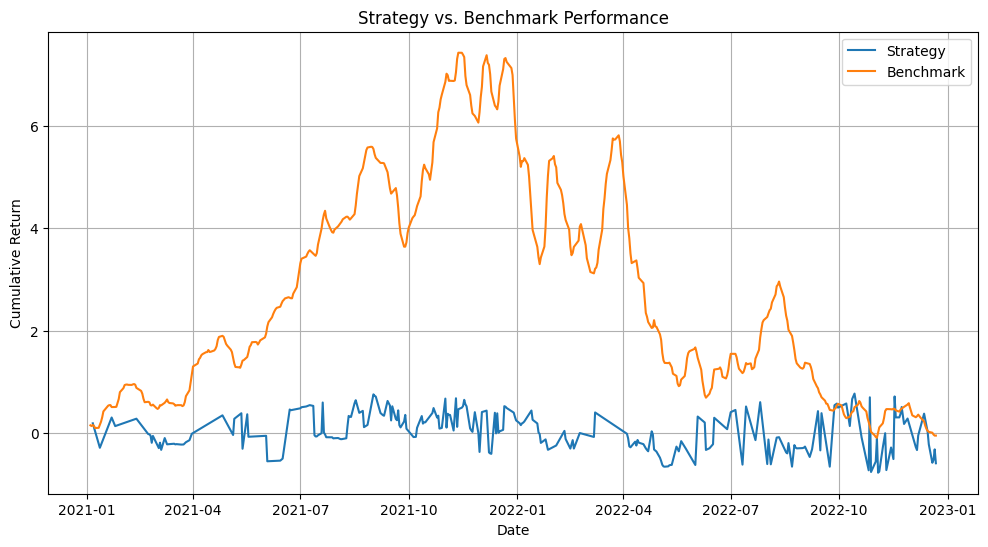

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(strategy_returns_grouped.index, strategy_returns_grouped, label='Strategy')
plt.plot(benchmark_returns_grouped.index, benchmark_returns_grouped, label='Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy vs. Benchmark Performance')
plt.legend()
plt.grid(True)
plt.show()

##META-LABELING

In [22]:
#Filter only the trades where the primary model gave a signal
meta_X = X_test[test_signals]
meta_proba = proba[test_signals]

In [23]:
#Create the true outcome foe each signaled trade
meta_y = (strategy_returns > 0).astype(int)

In [24]:
#Train the model
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

#Train a second model to learn only from the successful/failed trades
# Split meta data
meta_X_train, meta_X_test, meta_y_train, meta_y_test = train_test_split(
    meta_X, meta_y, test_size=0.2, random_state=42, stratify=meta_y)

In [25]:
# Explanation:
# - We want to train the meta-model on part of the confident signals and test on unseen confident signals.
# - stratify=meta_y ensures the ratio of profitable/unprofitable signals is similar in train and test sets.

In [26]:
# 2. Initialize Logistic Regression model
# 2. Define LightGBM Classifier
meta_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Explanation:
# - Random forest creates many decision trees and averages them.
# - max_depth limits tree depth for better generalization.

# 3. Train the meta-model on training confident signals
meta_model.fit(meta_X_train, meta_y_train)

# Explanation:
# - The model learns patterns in meta-features that differentiate good trades from bad.

[LightGBM] [Info] Number of positive: 147, number of negative: 148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498305 -> initscore=-0.006780
[LightGBM] [Info] Start training from score -0.006780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(learning_rate=0.05, max_depth=5, objective='binary',
               random_state=42)

In [27]:
# 4. Predict on the test set and evaluate
meta_proba = meta_model.predict_proba(meta_X_test)[:, 1]
custom_threshold = 0.7
meta_preds_thresh = (meta_proba > custom_threshold).astype(int)


print("Meta Accuracy (0.7 threshold):", accuracy_score(meta_y_test, meta_preds_thresh))
print("Meta ROC AUC:", roc_auc_score(meta_y_test, meta_proba))  # AUC stays same
print("Classification Report:\n", classification_report(meta_y_test, meta_preds_thresh))

# Explanation:
# - Accuracy and ROC AUC tell how well the meta-model can predict profitable trades.
# - Classification report shows precision, recall, F1-score which are crucial in financial decision-making.

Meta Accuracy (0.7 threshold): 0.6216216216216216
Meta ROC AUC: 0.6902848794740687
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.84      0.69        37
           1       0.71      0.41      0.52        37

    accuracy                           0.62        74
   macro avg       0.65      0.62      0.60        74
weighted avg       0.65      0.62      0.60        74



In [28]:
print("Train class distribution:\n", meta_y_train.value_counts())
print("Test class distribution:\n", meta_y_test.value_counts())

Train class distribution:
 Future_5d_Return
0    148
1    147
Name: count, dtype: int64
Test class distribution:
 Future_5d_Return
1    37
0    37
Name: count, dtype: int64


##TIME SERIES CROSS VALIDATION

In [29]:
from sklearn.model_selection import TimeSeriesSplit

In [30]:
#Initializing the splitter
tscv = TimeSeriesSplit(n_splits=5)

In [31]:
#Iterate through splits and train/test
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, proba)

    print(f"Accuracy: {acc:.4f}, ROC AUC: {roc:.4f}\n")

Fold 1
[LightGBM] [Info] Number of positive: 635, number of negative: 395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1030, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.616505 -> initscore=0.474739
[LightGBM] [Info] Start training from score 0.474739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

##MULTI STOCK META LABELING

In [32]:
# 1. For each stock, generate base model predictions and filter confident trades
meta_data_list = []
threshold = 0.7  # Keep your confident threshold

for ticker in tickers:
    # Subset data for this ticker
    X_ticker = X.loc[X.index.get_level_values('Ticker') == ticker]
    y_ticker = y.loc[y.index.get_level_values('Ticker') == ticker]
    data_ticker = data_all.loc[data_all.index.get_level_values('Ticker') == ticker].sort_index()

    # Predict probabilities using your trained base model
    proba_ticker = model.predict_proba(X_ticker)[:, 1]
    preds_ticker = (proba_ticker > threshold).astype(int)

    # Get actual future returns and labels
    future_returns_ticker = data_ticker.loc[X_ticker.index, 'Future_5d_Return']
    label_ticker = (future_returns_ticker > 0).astype(int)

    # Filter only confident trades
    confident_idx = preds_ticker == 1
    confident_index = X_ticker.index[confident_idx]

    # --- Compute rolling meta features ---
    # Rolling 5-day volatility of returns
    data_ticker['Return'] = data_ticker['Close'].pct_change()
    data_ticker['Rolling_Volatility'] = data_ticker['Return'].rolling(5).std().shift(1)

    # Rolling 5-day return trend
    data_ticker['Rolling_Trend'] = data_ticker['Return'].rolling(5).mean().shift(1)

    # Align meta features with confident trades
    meta_features = pd.DataFrame({
        'proba': proba_ticker[confident_idx],
        'volatility': data_ticker.loc[confident_index, 'Rolling_Volatility'],
        'trend': data_ticker.loc[confident_index, 'Rolling_Trend'],
    }, index=confident_index)

    # Meta label: was the trade profitable?
    meta_label = label_ticker[confident_idx]
    meta_label.name = 'Future_5d_Return'

    # Add ticker name for traceability
    meta_features['Ticker'] = ticker

    # Combine into one DataFrame
    meta_df = meta_features.copy()
    meta_df['Label'] = meta_label

    meta_data_list.append(meta_df)


In [33]:
# 2. Combine meta-labeling data from all stocks
meta_data_all = pd.concat(meta_data_list)
meta_data_all = meta_data_all.dropna()

In [34]:
meta_data_all

,,proba,volatility,trend,Ticker,Label
Date,Ticker,,,,,
2018-02-15,AAPL,0.757097,0.024485,0.010690,AAPL,1
2018-02-16,AAPL,0.742358,0.013377,0.022909,AAPL,1
2018-02-22,AAPL,0.817216,0.017144,0.008175,AAPL,1
2018-02-23,AAPL,0.828782,0.016202,0.006160,AAPL,1
2018-03-01,AAPL,0.810863,0.010532,0.008154,AAPL,1
...,...,...,...,...,...,...
2022-10-11,TSLA,0.760088,0.034895,-0.016084,TSLA,1
2022-11-21,TSLA,0.750769,0.021127,-0.016470,TSLA,1
2022-12-20,TSLA,0.824524,0.023186,-0.022151,TSLA,0


In [35]:
# 3. Split meta_data_all into features and labels
meta_X_all = meta_data_all[['proba', 'volatility', 'trend']]
meta_y_all = meta_data_all['Label']

In [36]:
# 4. Train-test split based on time (date) to avoid leakage
dates = meta_data_all.index.get_level_values('Date')
train_mask = dates < '2021-01-01'  # Adjust this split date as you like
meta_X_train = meta_X_all[train_mask]
meta_y_train = meta_y_all[train_mask]
meta_X_test = meta_X_all[~train_mask]
meta_y_test = meta_y_all[~train_mask]

In [37]:
from sklearn.utils import resample
import pandas as pd

# 1. Combine features and labels into one DataFrame
meta_train_df = pd.concat([meta_X_train, meta_y_train], axis=1)
meta_train_df.columns = list(meta_X_train.columns) + ['MetaLabel']

# 2. Separate majority and minority classes
df_majority = meta_train_df[meta_train_df['MetaLabel'] == 1]
df_minority = meta_train_df[meta_train_df['MetaLabel'] == 0]

# 3. Upsample minority class (0)
df_minority_upsampled = resample(df_minority,
                                 replace=True,                   # sample with replacement
                                 n_samples=len(df_majority),     # match majority class
                                 random_state=42)

# 4. Combine back the upsampled data
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# 5. Shuffle the data and reset index
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 6. Separate features and labels
meta_X_train_bal = df_balanced.drop('MetaLabel', axis=1)
meta_y_train_bal = df_balanced['MetaLabel']

In [38]:
# 5. Train meta-model (e.g., LightGBM)
from lightgbm import LGBMClassifier

meta_model = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
# Retrain the meta-model on the balanced data
meta_model.fit(meta_X_train_bal, meta_y_train_bal)

[LightGBM] [Info] Number of positive: 489, number of negative: 489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 978, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

LGBMClassifier(learning_rate=0.05, max_depth=5, random_state=42)

In [39]:
# 6. Evaluate meta-model
meta_preds = meta_model.predict(meta_X_test)
meta_proba = meta_model.predict_proba(meta_X_test)[:, 1]

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("Meta Model Accuracy:", accuracy_score(meta_y_test, meta_preds))
print("Meta Model ROC AUC:", roc_auc_score(meta_y_test, meta_proba))
print("Classification Report:\n", classification_report(meta_y_test, meta_preds))

Meta Model Accuracy: 0.8404255319148937
Meta Model ROC AUC: 0.6571699905033238
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.31      0.35        13
           1       0.89      0.93      0.91        81

    accuracy                           0.84        94
   macro avg       0.65      0.62      0.63        94
weighted avg       0.82      0.84      0.83        94

